# <h2 align="center"><font color = 'indianred'>Online Retail K-Means & Hierarchical Clustering</font></h2>

### <div class="alert alert-info">Introduction</div>

> While conducting a business, marketers spend a lot to attract new customers as compared to the expenses on retaining the current customers but they should realize that being able to hold existing customers is as crucial as finding new customers. If the rate of customer retention is greater than the rate of new customers, then the current trasactions will go down.


> In business, every deal might not be profitable to the customer and not every client might be interested to spend but it is important to ensure that the assets which are designated or deployed are in line with the benefit a client carries.

### <div class="alert alert-info">Objective</div>
> In this project, I'm analyzing how to segment the customers using Recency, Frequency, Monetary, and group the customers accordingly. This Analysis will help the marketers to choose the best set of customers and maximize the impact of customized plans focused on those targeted customers.

(RFM is an effective customer segmentation technique that engages marketers to distinguish and segment customers into similar clusters according to their behavior and target them with personalized promoting methodologies. This in turn makes good progress in customer engagement and retention and in this way it will generate higher rates of customer response and expand customer loyalty and lifetime)


## <font color = 'teal'>Loading the libraries</font>

In [1]:
# import required libraries for dataframe and visualization

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt


# import required libraries for clustering
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

## <font color = 'teal'>Data collection</font>

I used Kaggle’s Online Retail Data with different columns such as InvoiceNo, Invoice Date, Customer Id, Selling price, quantity, etc. which will be very helpful for the analysis.

In [2]:
df = pd.read_csv('OnlineRetail.csv', sep = ",", encoding="ISO-8859-1", header=0)

# shape of the dataframe
df.shape

(541909, 8)

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


## <font color = 'teal'>Data cleaning</font>

In [4]:
df.isnull().values.any()

True

#### Calculating the missing values as percentage contribution in the dataframe

In [5]:
df_null = round(100*(df.isnull().sum())/len(df),2)
df_null

InvoiceNo       0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
dtype: float64

We cannot replace the missing customer id values with their invoice no. because invoice no. is unique. Even a single customer can have multiple invoice no. if he/she decides to purchase at different times of the day. Although we are losing on 25% of the data corresponding to the customer id, the best option is to drop the missing values.


Corresponding to each of the customer ids, we have different parameters in the database. If the customer id itself is missing, there is no point of doing that analysis because we are analysing the customers depending on the parameters. If the customer id goes missing, we won't know which customer these parameters belong to.


Therefore, it is best to drop those sections.

#### Removing the null values using the ‘dropna’ method

In [6]:
df = df.dropna()
df.shape

(406829, 8)

In [7]:
import warnings
warnings.filterwarnings('ignore')

#### The customer id is in float form. As per the business understanding, ids will be labels (unique values)

In [8]:
df['CustomerID'] = df['CustomerID'].astype(str)

## <font color = 'teal'>Data Preparation</font>

#### We are going to analyze the Customers based on these 3 factors:

- R (Recency): Number of days since the last purchase
- F (Frequency): Number of tracsactions
- M (Monetary): Total amount of transactions (revenue contributed)

#### First, we shall be calculating monetary by summing up all the amounts of the customer. 

In [9]:
# New attribute is added: Monetary

df['Amount'] = df['Quantity']*df['UnitPrice']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34


The amount of transactions for each customer is fractionated. Therefore, we have to sum up all these fractionated values for each individual customer.

In [10]:
rfm_m = df.groupby('CustomerID')['Amount'].sum()
rfm_m = rfm_m.reset_index()
rfm_m.head()

,CustomerID,Amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


#### Next, we are calculating the frequency of customers by counting Invoice numbers of each customer. The more the count the more often the customer buys from the store.

In [11]:
# New attribute: Frequency

rfm_f = df.groupby('CustomerID')['InvoiceNo'].count()
rfm_f = rfm_f.reset_index()
rfm_f.columns = ['CustomerID','Frequency']
rfm_f.head()

,CustomerID,Frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


Merging the two dataframes



In [12]:
fm = pd.merge(rfm_m, rfm_f, on='CustomerID', how='inner')
fm.head()

,CustomerID,Amount,Frequency
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


#### Finally, we are calculating recency by subtracting the very recent date from the last transaction date of the customers.

In [13]:
# New Attribute : Recency
# Converting to datetime for proper datatype

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='%d-%m-%Y %H:%M')
df['InvoiceDate'].head()

0   2010-12-01 08:26:00
1   2010-12-01 08:26:00
2   2010-12-01 08:26:00
3   2010-12-01 08:26:00
4   2010-12-01 08:26:00
Name: InvoiceDate, dtype: datetime64[ns]

In [14]:
# First, computing the maximum date to know the last transaction date

max_date = max(df['InvoiceDate'])
max_date

Timestamp('2011-12-09 12:50:00')

In [15]:
# Then computing the difference between max date and transaction date

df['DateDiff'] = max_date - df['InvoiceDate']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount,DateDiff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00


In [16]:
# Computing the last transaction date to get the recency of customers

rfm_r = df.groupby('CustomerID')['DateDiff'].min()
rfm_r = rfm_r.reset_index()
rfm_r['DateDiff'] = rfm_r['DateDiff'].dt.days  # Extracting number of days only
rfm_r.head()

,CustomerID,DateDiff
0,12346.0,325
1,12347.0,1
2,12348.0,74
3,12349.0,18
4,12350.0,309


The fewer number of days resulted from the more recent customer purchased from the store.

In [17]:
# Merging all the dataframes to get the final RFM dataframe

rfm = pd.merge(fm, rfm_r, on = 'CustomerID', how='inner')
rfm.columns = ['CustomerID','Amount','Frequency','Recency']
rfm.head()

,CustomerID,Amount,Frequency,Recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


## <font color ='teal'>Treating the outliers</font>

Text(0.5, 0, 'Attributes')

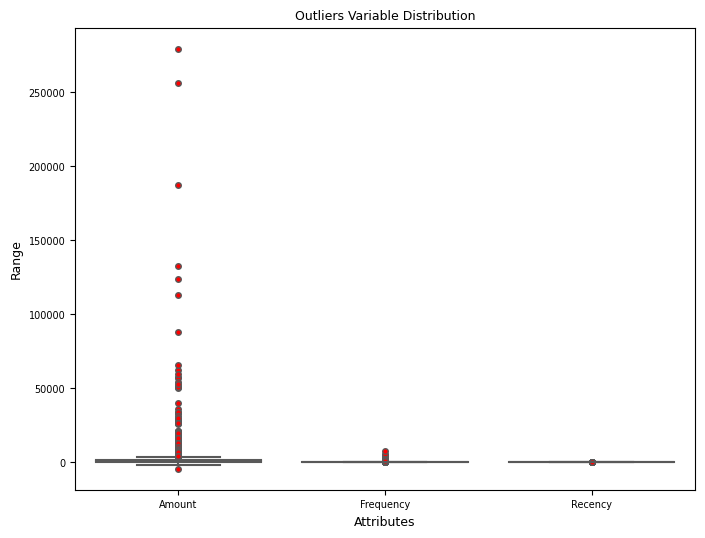

In [18]:
# Outlier Analysis of Amount Frequency and Recency

attributes = ['Amount','Frequency','Recency']
red_circle = dict(markerfacecolor='red', marker='o', markersize = 4)
plt.rcParams['figure.figsize'] = [8,6]
sns.boxplot(data = rfm[attributes], flierprops=red_circle, palette="Set2", whis=1.5, width=0.8)
plt.title("Outliers Variable Distribution", fontsize = 9, fontweight = 'light')
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.ylabel("Range", fontsize = 9, fontweight = 'light')
plt.xlabel("Attributes", fontsize = 9, fontweight = 'light')

In [19]:
# Removing (statistical) outliers for Amount

Q1 = rfm.Amount.quantile(0.05)
Q3 = rfm.Amount.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Amount >= Q1 - 1.5*IQR) & (rfm.Amount <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Recency
Q1 = rfm.Recency.quantile(0.05)
Q3 = rfm.Recency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Recency >= Q1 - 1.5*IQR) & (rfm.Recency <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Frequency
Q1 = rfm.Frequency.quantile(0.05)
Q3 = rfm.Frequency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Frequency >= Q1 - 1.5*IQR) & (rfm.Frequency <= Q3 + 1.5*IQR)]

## <font color ='teal'>Rescaling the attributes</font>

It is extremely important to rescale the variables so that they have a comparable scale.
There are two common ways of rescaling:

1. Min-Max scaling 
2. Standardisation (mean-0, variance-1) 

__We shall use Standardisation here.__ Standardization scales each input variable separately by subtracting the mean (called centering) and dividing by the standard deviation to shift the distribution to have a mean of zero and a standard deviation of one.

In [20]:
# Rescaling the attributes

rfm_df = rfm[['Amount', 'Frequency', 'Recency']]

scaler = StandardScaler()

# fit transform
rfm_df_scaled = scaler.fit_transform(rfm_df)

rfm_df_scaled.shape  # Reduced the data to a much more meaningful form

(4293, 3)

In [21]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['Amount', 'Frequency','Recency']
rfm_df_scaled.head()

,Amount,Frequency,Recency
0,-0.723738,-0.752888,2.301611
1,1.731617,1.042467,-0.906466
2,0.300128,-0.463636,-0.183658
3,0.277517,-0.044720,-0.738141
4,-0.533235,-0.603275,2.143188


## <font color = 'teal'>Building the model</font>

### Determining the optimal number of clusters

> A fundamental step for any unsupervised algorithm is to determine the optimal number of clusters into which the data may be clustered. The __K-means algorithm__ is an iterative, unsupervised ML algorithm that tries to partition the dataset into 'k' distinct clusters. It tries to make the intra-cluster data points as similar as possible while also keeping the clusters as far as possible. It assigns data points to a cluster such that the sum of the squared distance between the data points and the cluster’s centroid is at the minimum. The less variation we have within clusters, the more homogeneous the data points are within the same cluster.

### Elbow Method

> __The Elbow Method__ is one of the most popular methods to determine the optimal values of k. The method consists of plotting the explained variation as a function of the number of clusters and picking the elbow of the curve as the number of clusters to use.

> This method is a graphical representation of finding the optimal 'K' in a K-means clustering that works by finding __WCSS__ (Within-Cluster Sum of Square) i.e. the sum of the square distance between points in a cluster and the cluster centroid. We try to make sure that we get the minimum value of WCSS so that we may get the minimum intra-cluster distance. If we keep increasing the number of the centroids, the value of WCSS will decrease.

I have plotted the cluster numbers on the horizontal-axis and their respective score on the vertical axis.

> As an initialization of the centroids, __K-means++ algorithm__ is used here to improve the quality of the centroids. Whenever we are randomly initializing the centroids, it will make sure that the centroids are initialized as far away as possible from each other, so that the clusters are not biased in any form every time we are getting uniform clusters in K-means algorithm.

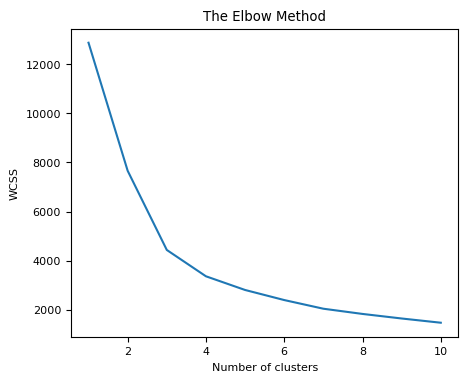

In [22]:
wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(rfm_df_scaled)
    wcss.append(kmeans.inertia_)
    # Inertia measures how well a dataset was clustered by K-Means.
    # Calculated by measuring the distance between each data point and its centroid, squaring this distance, and summing these squares across one cluster.

plt.figure(figsize=(5,4))
plt.rcParams['font.size'] = 8
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

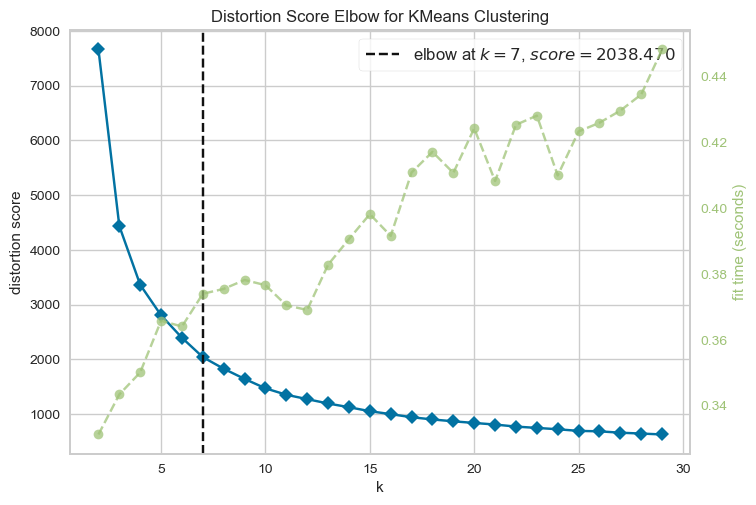

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [23]:
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
# K is range of number of clusters.

visualizer = KElbowVisualizer(model, k=(2,30), timings= True)
visualizer.fit(rfm_df_scaled)        # Fit data to visualizer
visualizer.show()                    # Finalize and render figure

In [24]:
kmeans = KMeans(n_clusters=7, max_iter=50, random_state = 20)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=7, random_state=20)

In [25]:
kmeans.labels_

array([1, 3, 0, ..., 6, 0, 4])

In [26]:
kmeans.cluster_centers_

array([[-0.37639244, -0.39750403, -0.53588584],
       [-0.53000288, -0.55180722,  2.02716419],
       [ 5.1071943 ,  2.78411366, -0.74453845],
       [ 2.2102774 ,  1.28112834, -0.68974825],
       [ 0.42764122,  0.60814297, -0.60377431],
       [ 1.20450801,  3.68852546, -0.72959316],
       [-0.42611594, -0.45914555,  0.6854634 ]])

__These are the centroids of each of those 7 clusters that we have prepared.__

In [27]:
# Making a copy of the previous dataframe and adding a new column to it

cluster_data= rfm_df.copy()

cluster_data['cluster_predicted'] = kmeans.fit_predict(rfm_df_scaled)

__fit_predict() method will fit and perform predictions over training data thus, is more appropriate when performing operations such as clustering.__

In [28]:
cluster_data.head(10)

,Amount,Frequency,Recency,cluster_predicted
0,0.00,2,325,1
1,4310.00,182,1,3
2,1797.24,31,74,0
3,1757.55,73,18,4
4,334.40,17,309,1
5,1545.41,95,35,4
6,89.00,4,203,6
7,1079.40,58,231,6
8,459.40,13,213,6
9,2811.43,59,22,4


#### The customers are divided into 7 groups and we shall be visualizing cluster_predicted based on Amount, Frequency and Recency with the help of boxplot.

Text(0.5, 1.0, 'Cluster ID vs Monetary')

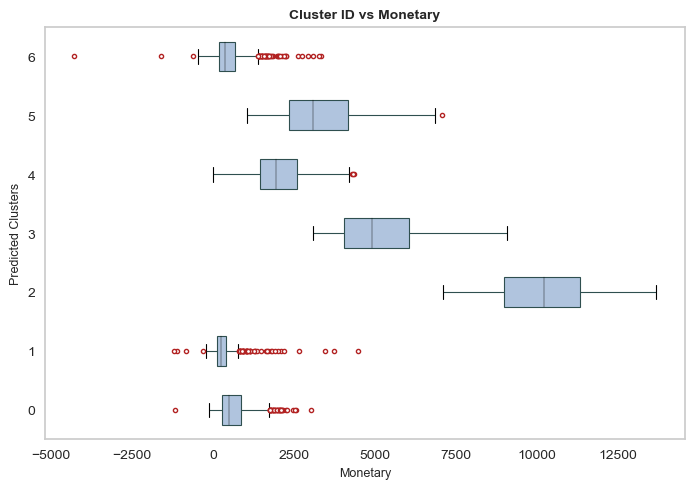

In [29]:
red_circle = dict(markerfacecolor='white', marker='o', markeredgecolor='firebrick', markersize=3)
boxprops = {'facecolor': 'lightsteelblue', 'edgecolor': 'darkslategrey', 'linewidth': 0.8}
whiskerprops = {'color': 'darkslategrey', 'linewidth': 0.8}
capprops = {'color': 'black', 'linewidth': 0.8}
medianprops = {'color': 'black', 'linewidth': 0.3}


cluster_data.boxplot(by=['cluster_predicted'], column =['Amount'], 
            vert = False,
            flierprops=red_circle, 
            patch_artist=True, 
            boxprops=boxprops, 
            whiskerprops=whiskerprops, 
            capprops=capprops, 
            medianprops=medianprops,
            grid = False)

plt.suptitle('')
plt.ylabel('Predicted Clusters', fontsize = 9)
plt.xlabel('Monetary', fontsize = 9)
plt.title('Cluster ID vs Monetary', fontsize=10, fontweight = 'bold')

#### <div class="alert alert-info">Monetary Analysis:</div>
> __Customers who belong to the cluster 3 (indexed as 2) are the ones who spend the most, i.e. maximum revenue has been collected from these customers. For the clusters 4 and 6 (indexed as 3 and 5 respectively), the data is more variable especially on the upper levels.__

Text(0.5, 1.0, 'Cluster ID vs Frequency')

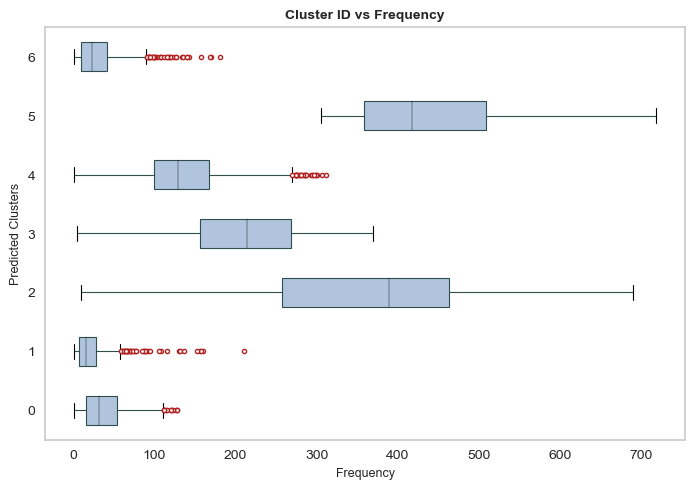

In [30]:
red_circle = dict(markerfacecolor='white', marker='o', markeredgecolor='firebrick', markersize=3)
boxprops = {'facecolor': 'lightsteelblue', 'edgecolor': 'darkslategrey', 'linewidth': 0.8}
whiskerprops = {'color': 'darkslategrey', 'linewidth': 0.8}
capprops = {'color': 'black', 'linewidth': 0.8}
medianprops = {'color': 'black', 'linewidth': 0.3}


cluster_data.boxplot(by=['cluster_predicted'], column =['Frequency'], 
            vert = False,
            flierprops=red_circle, 
            patch_artist=True, 
            boxprops=boxprops, 
            whiskerprops=whiskerprops, 
            capprops=capprops, 
            medianprops=medianprops,
            grid = False)

plt.suptitle('')
plt.ylabel('Predicted Clusters', fontsize = 9)
plt.xlabel('Frequency', fontsize = 9)
plt.title('Cluster ID vs Frequency', fontsize=10, fontweight = 'bold')

#### <div class="alert alert-info">Frequency Analysis:</div>
> __Customers who belong to the clusters 6 are the most frequent visitors followed by the ones who belong to the cluster 3 (indexed as 5 and 2 respectively), i.e. these customers have made maximum number of transactions. The data in cluster 3 varies too much on both the upper and lower levels and therefore inconsistent for making predictions. The data in cluster 6 is more variable especially on the upper levels.__

Text(0.5, 1.0, 'Cluster ID vs Recency')

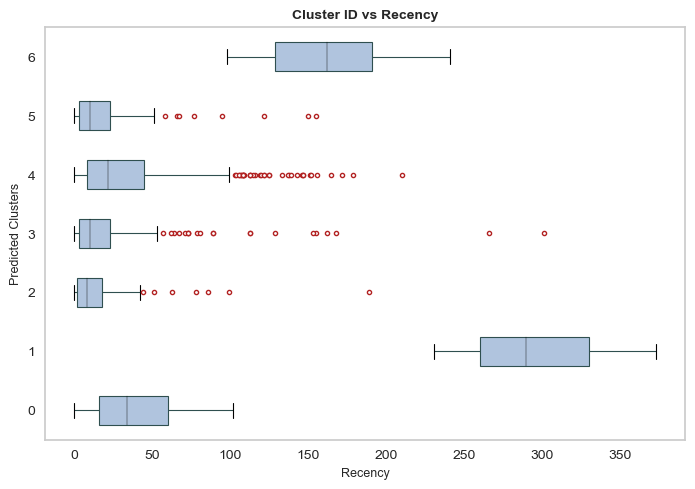

In [31]:
red_circle = dict(markerfacecolor='white', marker='o', markeredgecolor='firebrick', markersize=3)
boxprops = {'facecolor': 'lightsteelblue', 'edgecolor': 'darkslategrey', 'linewidth': 0.8}
whiskerprops = {'color': 'darkslategrey', 'linewidth': 0.8}
capprops = {'color': 'black', 'linewidth': 0.8}
medianprops = {'color': 'black', 'linewidth': 0.3}


cluster_data.boxplot(by=['cluster_predicted'], column =['Recency'], 
            vert = False,
            flierprops=red_circle, 
            patch_artist=True, 
            boxprops=boxprops, 
            whiskerprops=whiskerprops, 
            capprops=capprops, 
            medianprops=medianprops,
            grid = False)

plt.suptitle('')
plt.ylabel('Predicted Clusters', fontsize = 9)
plt.xlabel('Recency', fontsize = 9)
plt.title('Cluster ID vs Recency', fontsize=10, fontweight = 'bold')

#### <div class="alert alert-info">Recency Analysis:</div>
> __Customers who belong to the clusters 3, 4 and 6 (indexed as 2, 3 and 5 respectively) have more or less the minimum number of days since their last purchase, followed by the ones in clusters 1 and 5 (indexed as 0 and 4 respectively). From the observation, it is obvious that the customers belonging to cluster 2 (indexed as 1) have already been churning.__

## <font color = 'teal'>An alternate approach: Hierarchical Clustering</font>

### Agglomerative Hierarchical Clustering with Ward's Linkage

> __Agglomerative clustering__ starts with each observation as its own cluster. The two closest clusters are joined into one cluster. The next closest clusters are grouped together and this process continues until there is only one cluster containing the entire data set.

> __Ward´s linkage__ is a popular metrics in hierarchical clustering. The idea has much in common with analysis of variance (ANOVA). The linkage function specifying the distance between two clusters is computed as the increase in the "error sum of squares" (ESS) after fusing two clusters into a single cluster. Ward´s Method seeks to choose the successive clustering steps so as to minimize the increase in ESS at each step. Basically Ward’s method approach does well in separating clusters if there is noise between clusters.

> __Dendrogram__ is a technique specific to the agglomerative hierarchical method of clustering. The method starts by considering each point as a separate cluster and starts joining points to clusters in a hierarchical fashion based on their distances. To get the optimal number of clusters for hierarchical clustering, we make use a dendrogram which is tree-like chart that shows the sequences of merges or splits of clusters.

__The bigger the distance between two links, the bigger the distance in terms of chosen features__

In [32]:
mergings = linkage(rfm_df_scaled, method="ward", metric='euclidean')

# Optimal number of clusters is found to be 3
cluster_labels = cut_tree(mergings, n_clusters=3).reshape(-1, )

ag_cluster = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean')
ag_cluster.fit(rfm_df_scaled)

AgglomerativeClustering(affinity='euclidean', n_clusters=3)

In [33]:
cluster_labels

array([0, 1, 2, ..., 0, 2, 2])

In [34]:
# Assign cluster labels and then fit_predict()

cluster_data2= rfm.copy()
cluster_data2['Cluster_labels'] = cluster_labels
cluster_data2['Cluster_predicted'] = ag_cluster.fit_predict(rfm_df_scaled)
cluster_data2.head(10)

,CustomerID,Amount,Frequency,Recency,Cluster_labels,Cluster_predicted
0,12346.0,0.00,2,325,0,2
1,12347.0,4310.00,182,1,1,1
2,12348.0,1797.24,31,74,2,0
3,12349.0,1757.55,73,18,2,0
4,12350.0,334.40,17,309,0,2
5,12352.0,1545.41,95,35,2,0
6,12353.0,89.00,4,203,0,2
7,12354.0,1079.40,58,231,0,2
8,12355.0,459.40,13,213,0,2
9,12356.0,2811.43,59,22,2,0


Text(0.5, 1.0, 'Cluster Labels vs Monetary')

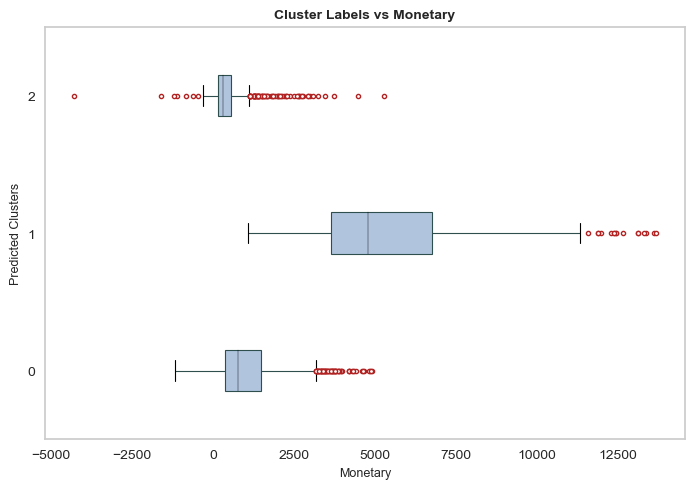

In [35]:
# Plotting CLuster_predicted against Amount

red_circle = dict(markerfacecolor='white', marker='o', markeredgecolor='firebrick', markersize=3)
boxprops = {'facecolor': 'lightsteelblue', 'edgecolor': 'darkslategrey', 'linewidth': 0.8}
whiskerprops = {'color': 'darkslategrey', 'linewidth': 0.8}
capprops = {'color': 'black', 'linewidth': 0.8}
medianprops = {'color': 'black', 'linewidth': 0.3}


cluster_data2.boxplot(by=['Cluster_predicted'], column =['Amount'], 
            vert = False,
            flierprops=red_circle, 
            patch_artist=True, 
            boxprops=boxprops, 
            whiskerprops=whiskerprops, 
            capprops=capprops, 
            medianprops=medianprops,
            grid = False)

plt.suptitle('')
plt.ylabel('Predicted Clusters', fontsize = 9)
plt.xlabel('Monetary', fontsize = 9)
plt.title('Cluster Labels vs Monetary', fontsize=10, fontweight = 'bold')

#### <div class="alert alert-info">Monetary Analysis:</div>

> __Customers who belong to cluster 2 (indexed as 1) are the ones with comparatively higher amount of transactions. The data in cluster 2 is more variable especially on the upper levels. Therefore, maximum revenue can be generated from these customers.__

Text(0.5, 1.0, 'Cluster Labels vs Frequency')

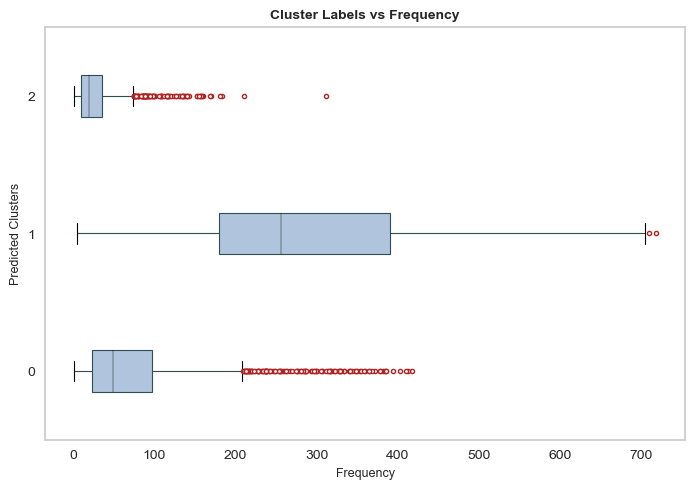

In [36]:
# Plotting CLuster_predicted against Frequency


red_circle = dict(markerfacecolor='white', marker='o', markeredgecolor='firebrick', markersize=3)
boxprops = {'facecolor': 'lightsteelblue', 'edgecolor': 'darkslategrey', 'linewidth': 0.8}
whiskerprops = {'color': 'darkslategrey', 'linewidth': 0.8}
capprops = {'color': 'black', 'linewidth': 0.8}
medianprops = {'color': 'black', 'linewidth': 0.3}


cluster_data2.boxplot(by=['Cluster_predicted'], column =['Frequency'], 
            vert = False,
            flierprops=red_circle, 
            patch_artist=True, 
            boxprops=boxprops, 
            whiskerprops=whiskerprops, 
            capprops=capprops, 
            medianprops=medianprops,
            grid = False)

plt.suptitle('')
plt.ylabel('Predicted Clusters', fontsize = 9)
plt.xlabel('Frequency', fontsize = 9)
plt.title('Cluster Labels vs Frequency', fontsize=10, fontweight = 'bold')

#### <div class="alert alert-info">Frequency Analysis:</div>

> __Although majority of customers in cluster 2 (indexed as 1) are the most frequent buyers, the data varies too much on both the upper and lower levels (more variable on the upper levels).__

Text(0.5, 1.0, 'Cluster Labels vs Recency')

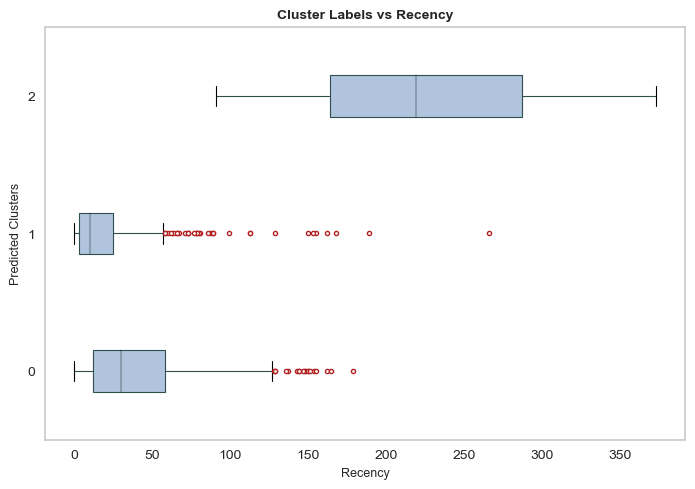

In [37]:
# Plotting CLuster_predicted against Recency


red_circle = dict(markerfacecolor='white', marker='o', markeredgecolor='firebrick', markersize=3)
boxprops = {'facecolor': 'lightsteelblue', 'edgecolor': 'darkslategrey', 'linewidth': 0.8}
whiskerprops = {'color': 'darkslategrey', 'linewidth': 0.8}
capprops = {'color': 'black', 'linewidth': 0.8}
medianprops = {'color': 'black', 'linewidth': 0.3}


cluster_data2.boxplot(by=['Cluster_predicted'], column =['Recency'], 
            vert = False,
            flierprops=red_circle, 
            patch_artist=True, 
            boxprops=boxprops, 
            whiskerprops=whiskerprops, 
            capprops=capprops, 
            medianprops=medianprops,
            grid = False)

plt.suptitle('')
plt.ylabel('Predicted Clusters', fontsize = 9)
plt.xlabel('Recency', fontsize = 9)
plt.title('Cluster Labels vs Recency', fontsize=10, fontweight = 'bold')

#### <div class="alert alert-info">Recency Analysis:</div>

> __Customers who belong to cluster 2 (indexed as 1) are the ones with least number of days since their last purchase, i.e. these customers are recent buyers and should be treated with top priority. Customers belonging to cluster 3 (indexed as 2) are of least importance since it is most likely that they have began churning already.__

__Project done by Pratiek Sarkar__